In [2]:
%load_ext autoreload
%autoreload 2

In [145]:
import networkx as nx
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Traffic simulator
_Author: Michael girardot_


Traffic regulation is a well known problem for reinforcement learning. However one could not expect deploying artificial intelligence without simulation. In this experiment I would like to develop a simple traffic simulation that I could use to learn and test current deep-reinforcement learning (RL) technics. 
Existing tools for traffic simulation includes the [SUMO simulator](http://www.dlr.de/ts/en/desktopdefault.aspx/tabid-9883/16931_read-41000/). Such advanced tools are not fit for this task since one needs to process raw images from the GUI. On the other hand, reinforcement learning frameworks such as [gym](https://github.com/openai/gym) from OpenAI are great tools to test deep-RL with its simple API. I will follow the gym design guidelines to design this traffic simulator. Designing my own traffic simulator will allow to fully understand the environment and control its complexity.

## Design

Graph is a natural choice for modeling a transportation network. I will use the [networkx](https://networkx.github.io/documentation/stable/) library that comes with algorithms and drawing capabilities. Geographics coordinates are represented by nodes and roads by edges.

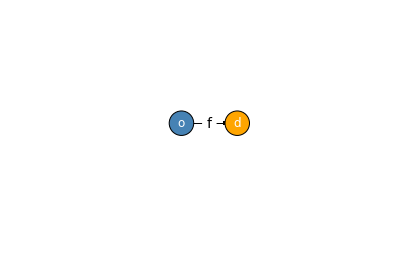

In [16]:
from graph_definition import draw_graph_definition
draw_graph_definition()

This is a directed graph with nodes and edges attributes (o,d and f) corresponding to the number of cars at that position and the flow of cars per time step, respectively. 

At each time step, we can update the network as follow:

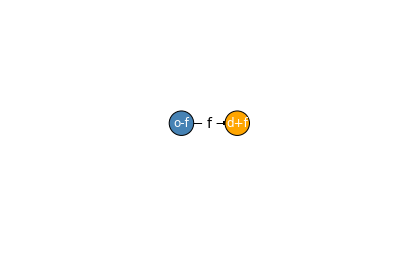

In [17]:
draw_graph_definition(o='o-f',d='d+f')

Cars at each node are stored in a [“First In First Out”](https://en.wikipedia.org/wiki/FIFO_%28computing_and_electronics%29) queue. Thus a car that just arrive at a node can spend several steps at that node until other cars that arrived before move to another node. This will allow traffic jams situations where the flow is suboptimal for the number of cars present.

## `Traffic` class

In [99]:
from graph_trafic import Traffic

The transportation network can be randomly generated or specified by an edge list. 

* **`edge_list`** parameter:

This is a list of tuples of (start_node, end_node, weight dict)
The weight dict contains the name of the parameter (`w`) and its value corresponding to the car flow per time step.

* **`car_count`** parameter:

The number of cars specified are generated and randomly distributed over the network nodes. We will follow **`car_1`** to compute traffic statistics.


In [118]:
G = Traffic([(0,1, {'w': 1})], car_count=3)

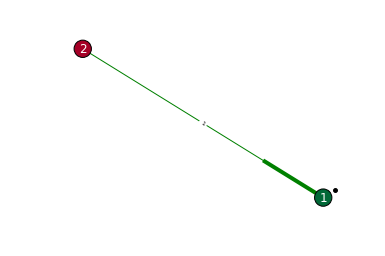

In [119]:
G.plot_graph()
plt.show()

## The `step()` function

In [120]:
print(G.G.nodes(data=True))

[(0, {'tags': deque(['car_0', 'car_2'])}), (1, {'tags': deque(['car_1'])})]


Cars on node 0 will move to node 1 when we use the `step()` function.

In [121]:
G.step()
print(G.G.nodes(data=True))

[(0, {'tags': deque(['car_2'])}), (1, {'tags': deque(['car_1', 'car_0'])})]


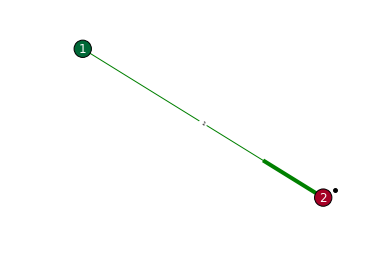

In [122]:
G.plot_graph()
plt.show()

## The `state()` function

At each time step we can observe the environement with the state function. This will return the position of **`car_1`** and the loading of each nodes.

In [123]:
G.state()

array([ 1.,  1.,  2.])

We will use this vector to make decisions and change the environement with the **`action()`** function.

## The `action()` function

In this simple simulation, the only action that we can take is to switch the red lights at intersections.

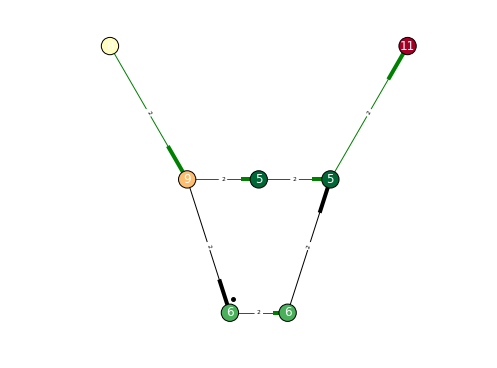

In [132]:
# Let's define a simple network
edge_list = [(0, 1, {'w': 2}),
             (1, 2, {'w': 2}),
             (2, 3, {'w': 2}),
             (3, 6, {'w': 2}),
             (1, 4, {'w': 2}),
             (4, 5, {'w': 2}),
             (5, 3, {'w': 2})]

G = Traffic(edge_list=edge_list, layout='spectral')
plt.figure(figsize=(8,6))
G.plot_graph()
plt.show()

In [133]:
# the controlable red lights are at intersections
G.gates

[1, 3]

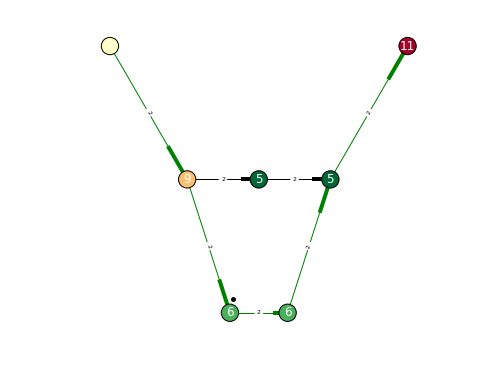

In [134]:
# we can cycle through the positions of each red light with a vector of bool
G.action([True,True])

plt.figure(figsize=(8,6))
G.plot_graph()
plt.show()

Open roads are visualized as green edges. Closed roads are black.

## The goal
We would like to design an agent that control the red light to optimize the traffic in our network. Thus the goal of our agent is to move cars to the destination as fast as possible. 

We have at our disposal the position of **`car_1`**:

In [135]:
G.car1pos

4

The destination node:

In [136]:
G.end

6

Our agent will be rewarded with a score of 20 when `car_1` reach the destination node. Otherwise, it will be rewarded with a score of -1. This negative score force a solution in a minimum steps possible.

In [137]:
G.reward()

-1

In [138]:
G.car1pos = G.end
G.reward()

20

# The random agent

Using a very simple network, we can mesure the base performance of a random agent that will switch red lights using a binomial law.

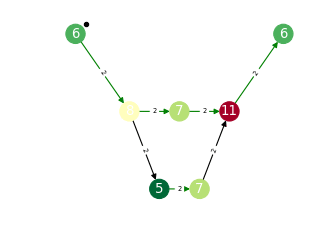

In [140]:
from IPython.display import Image, HTML, display

with open('traffic.gif','rb') as f:
    display(Image(data=f.read()), format="gif")

In [163]:
epochs = 10000

random_agent = []
for _ in range(epochs):
    G = Traffic(edge_list=edge_list)
    total_reward = 0
    for i in range(30):
        vector = np.random.binomial(1, .5, 2)
        G.action(vector)
        state, reward, finished = G.step(refeed=True)
        total_reward += reward
        if finished:
            break
    random_agent.append(total_reward)

# No Agent

We can evaluate the collected rewards when doing nothing to regulate the traffic.

In [165]:
epochs = 10000

No_agent = []
for _ in range(epochs):
    G = Traffic(edge_list=edge_list)
    total_reward = 0
    for i in range(30):
        vector = np.array([0.,0.]) # No switch
        G.action(vector)
        state, reward, finished = G.step(refeed=True)
        total_reward += reward
        if finished:
            break
    No_agent.append(total_reward)

# Schedule agent

We can switch the red lights according to a fixed sequence or schedule. This is the most common way to regulate the traffic. We will switch every red lights every 2 steps. 

In [218]:
epochs = 10000

Schedule_agent_2_steps = []
for _ in range(epochs):
    G = Traffic(edge_list=edge_list)
    total_reward = 0
    for i in range(30):
        if i%2 == 0:
            vector = np.array([1.,1.]) # switch
        else:
            vector = np.array([0.,0.]) # No switch
        G.action(vector)
        state, reward, finished = G.step(refeed=True)
        total_reward += reward
        if finished:
            break
    Schedule_agent_2_steps.append(total_reward)

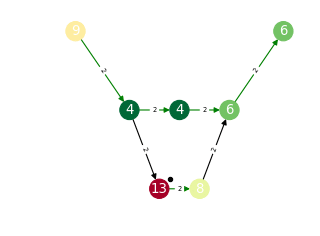

In [225]:
with open('Schedule_traffic.gif','rb') as f:
    display(Image(data=f.read()), format="gif")

# Comparing agents

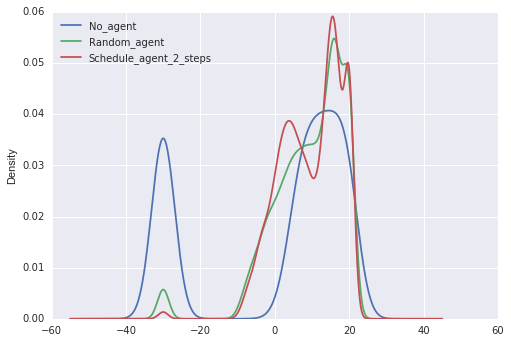

In [224]:
df = pd.DataFrame({'No_agent': No_agent, 
                   'Random_agent': random_agent, 
                   'Schedule_agent_2_steps': Schedule_agent_2_steps
                  })
df.plot.kde()
plt.show()

* Without an agent to control the traffic, we observe about half of the cars reaching destination in the defined time frame (30 steps).


* A random agent is able to decrease the fraction of cars that do not reach destination (-30) in the defined time frame. Thus turning red lights on and off even randomly is good to regulate the network.


* Using a schedule can decrease drastically the number of cars that do not reach destination. However, we observe significantly more traffic jams (shoulders in between -30 and +20) compared to the random agent.


To solve this, I would like to develop an agent that can regulate traffic such as:
* every car reach destination within the defined time frame
* reduce traffic jams observed with the schedule agent